# Web Scraping Job offers in order to find usefull information

Possible to do:
- GUI input
- Other sources than linkedin
- More than first page
- Check the structured data from linkedin page

## Setting up

### Importing libraries

In [130]:
#external
import requests # makes HTTP requests in Python
from bs4 import BeautifulSoup # makes it easy to scrape information from web pages
from selenium import webdriver # automates web browser interaction
import pandas as pd # data analysis and manipulation tool
import advertools as adv # provides options for text analysis 
import matplotlib.pyplot as plt # creates visualizations in Python
from wordcloud import WordCloud # generates word clouds in Python
import numpy as np # makes it easier to work with arrays, matrices etc.

#built-in
import os # provides a way of using operating system dependent functionality
import re # provides regular expression matching operations
import time # provides various time-related functions
from collections import Counter # provides specialized container datatypes - here a dict subclass for counting hashable objects
import random #  implements pseudo-random number generators
import json

### Setting up project folders

In [80]:
# Defining current folder as our main directory
dirname = os.getcwd()

# location folders variables
data_in = dirname + "\\da_data_raw\\"
data_out = dirname + "\\da_data_workfiles\\"

  
# checking if data_in path is not present, then create it.
if not os.path.exists(data_in):
    os.makedirs(data_in)
    print(f"Directory Created:{data_in}\n")
    
# checking if data_out path is not present then create it.
if not os.path.exists(data_out):
    os.makedirs(data_out)
    print(f"Directory Created:{data_out}\n")
    

print(f"Main directory: {dirname}")
print(f"Raw data folder: {data_in}")
print(f"Analysis and workfile folder: {data_out}")
       

Main directory: c:\Users\33671\Documents\Python\Job_Offers_Analyser
Raw data folder: c:\Users\33671\Documents\Python\Job_Offers_Analyser\da_data_raw\
Analysis and workfile folder: c:\Users\33671\Documents\Python\Job_Offers_Analyser\da_data_workfiles\


### Defining inputs

In [81]:
# specifying variables input for searching
job_title_input = 'Data Analyst'
location_input = 'France'

### Generating Linkedin url

In [82]:
# trasnforming the inputs to a valid format for the url
job_title_key = '%20'.join(job_title_input.split(" "))
location_key = '%20'.join(location_input.split(" "))

In [83]:
# generating the initial linkedin url
url = f'https://www.linkedin.com/jobs/search?keywords={job_title_key}&location={location_key}'

In [84]:
# Web scrapper for infinite scrolling page 
driver = webdriver.Firefox()
driver.get(url)
time.sleep(2)  # Allow 2 seconds for the web page to open
scroll_pause_time = 2 # You can set your own pause time. My laptop is a bit slow so I use 2 sec
screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
i = 1

while True:
    # scroll one screen height each time
    driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
    i += 1
    time.sleep(scroll_pause_time)
    # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
    scroll_height = driver.execute_script("return document.body.scrollHeight;")  
    # Break the loop when the height we need to scroll to is larger than the total scroll height
    if (screen_height) * i > scroll_height:
        break

In [85]:
# # get data from the url 
# initial_page = requests.get(url)

# # ensure the get request is successful
# # if we use a requests.models.Response instance in a conditional expression, it evaluates to True if the status code is between 200 and 400, and False otherwise
# if initial_page:
#     print('Success!')
# else:
#     print('An error has occurred.')

In [86]:
soup_initial_page = BeautifulSoup(driver.page_source, "html.parser")

In [87]:
# # Exploring the list of all links from the page. Select code and "CTRL + /" to activate
# for link in soup_initial_page.find_all('a'):
#    print(link.get('href'))  

After exploring the soup object, we can see that the page contains multiple links. 

We will select those related to job offers. They contain: `linkedin.com/jobs/`

## Extracting Job Offers urls to a list

In [88]:
# Empty list to store the output
job_links = []

# For loop that iterates over all the <li> tags
for h in soup_initial_page.findAll('li'):
    
    # looking for anchor tag inside the <li>tag
    a = h.find('a')
    try:
        
        # looking for href inside anchor tag
        if 'href' in a.attrs:
            
            # storing the value of href in a separate variable
            link = a.get('href')
              
            # appending the url to the output list
            job_links.append(link)
              
    # if the list does not have a anchor tag or
    # does not has a href params we pass
    except:
        pass

print(f'Number of links extracted: {len(job_links)}')

Number of links extracted: 181


In [89]:
job_links = [link for link in job_links if "linkedin.com/jobs/" in link]
print(f'Number of job offers links: {len(job_links)}')

if len(job_links) == 175:
    print("This is the expected number of links")
else:
    print("Warning: this is not the expected number of links")

Number of job offers links: 171


## Scraping job offers
After inspecting linkedin pages, we see that the actual content of the page is hosted between `show-more-less-html__markup` class. This is what we will look for to populate the job offers content.

check https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python to add a limit to the loop

In [128]:
# scraping URLs' contents and combining into one string
# creating text string
words_str = ''
job_info_str = ''
i = 0

# try/except to avoid mistakes
time.sleep(random.uniform(1.0, 2.5))
try:
    for link in job_links:
        # looping through the links
        req = requests.get(link)
        # Taking into account non 200 responses to try again with a bigger timer
        if req:
            i += 1
        else:
            print(req.status_code)
            time.sleep(5) # I had to to put an
            req = requests.get(link)
        # converting to BeautifulSoup
        soup_job_offer = BeautifulSoup(req.text)
        # extracting job content (within a div with a specific class) and job info (within a script with a specific type)
        job_content = soup_job_offer.find('div', class_="show-more-less-html__markup").text
        job_info = soup_job_offer.find('script', type="application/ld+json").text 
        # appending to a string and converting to lowercase
        words_str = f'{words_str} {job_content}'.lower()
        job_info_str = f'{job_info_str} {job_info}'.lower()
        # pausing for few seconds to avoid 'error 429 too many requests'. Also using random to be safe
        time.sleep(random.uniform(1.0, 2.5))
except Exception as e:
    pass

# previewing strings contents
print(f"This an overview of the string generated:\n {words_str[:400]}")
print(f"\nNumber of characters countained - including spaces: {len(words_str)}")
print(f"\nNumber of HTTP 200 responses: {i}")

429
429
429
429
429
429
429
This an overview of the string generated:
  
depuis plus de 40 ans, locabri développe la gamme référence de bâtiments modulaires démontables à usage de stockage industriel. de conception acier ou aluminium, ces bâtiments peuvent être couverts de toile textile ou de bardage acier.avec un parc locatif de 350 000 m² disponibles de structure modulaire, locabri est devenu le premier fournisseur de bâtiments modulaires pour l’industrie, les coll

Number of characters countained - including spaces: 381792

Number of HTTP 200 responses: 110


## Plotting a word cloud

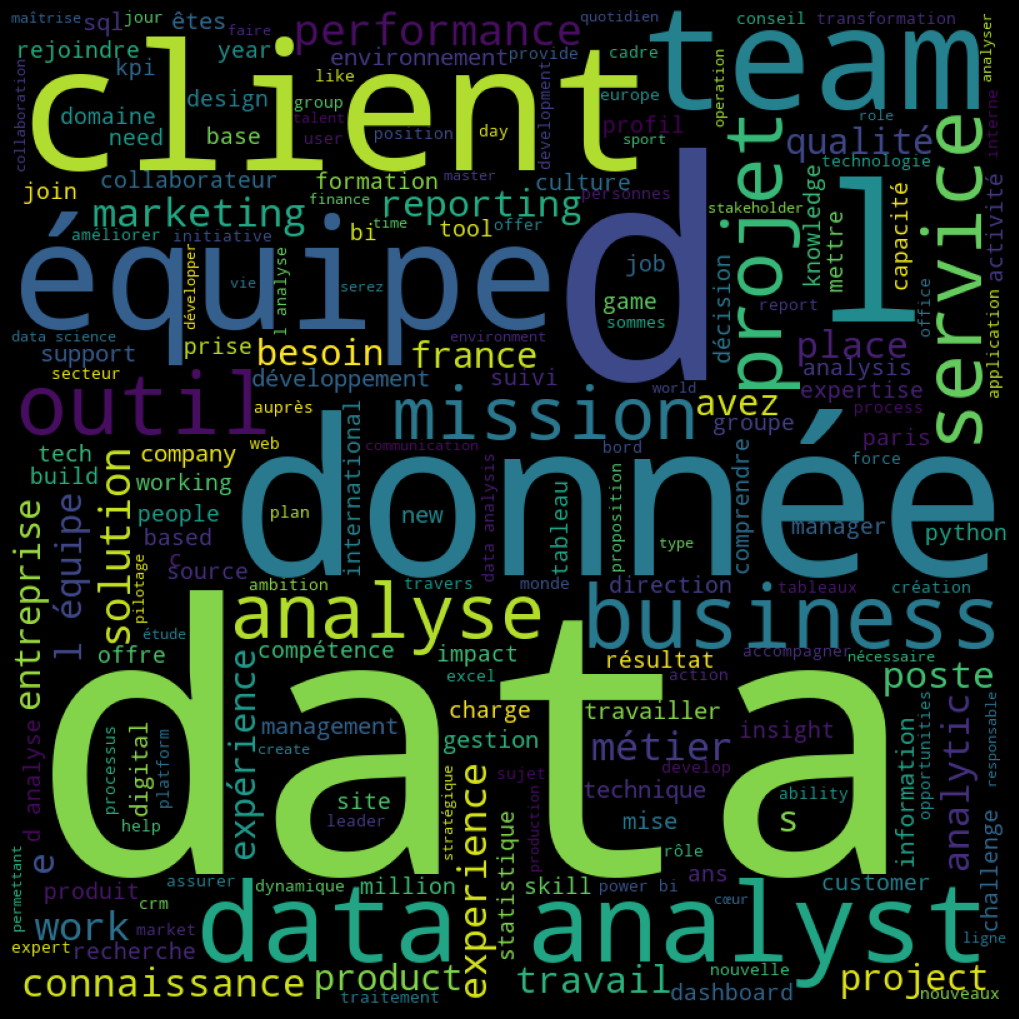

In [106]:
# plotting word cloud
# joining the sets of stopwords: English and French
sw_en_fr = adv.stopwords['english'].union(adv.stopwords['french'])

# generating word cloud with WordCloud module
wordcloud = WordCloud(width=800, height=800,
                      background_color='black',
                      stopwords=sw_en_fr,
                      min_font_size=10
                      ).generate(words_str)

# plotting the WordCloud image with matplotlib
plt.figure(figsize=(10, 10), facecolor='Black')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# printing the plot
plt.show()

## Creating a dataframe

In [107]:
# creating a list from the string we had
words_list = words_str.split()

# creating a pandas dataframe from the list, transformed to a dictionnary. I need to look into it to make something less ugly
df_words = pd.DataFrame.from_dict([Counter(words_list)]).T

# renaming and sorting the df
df_words.rename(columns = {0: 'word_count'}, inplace=True)
df_words.index.names=['word']
df_words.reset_index(inplace=True)
df_words.sort_values(by=['word_count'], inplace = True, ascending=False)

# Overview of the result
print(f"{len(words_str)} characters string converted to {df_words.shape[0]} unique worlds and {df_words['word_count'].sum()} total occurences\n")
print(f"Overview of the dataframe:\n {df_words.head()}")


568582 characters string converted to 15130 unique worlds and 82006 total occurences

Overview of the dataframe:
     word  word_count
2     de        3452
47    et        2264
418  and        1612
112  des        1467
7     la        1170


## Generating raw csv files

This could be useful if we want to do a broader analysis later on

In [108]:
# generating a raw csv file with timestamp including in the name
# using the convention _ to delimit units and - to delimit words from the same limit
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = "raw-words_" + job_title_input.replace(" ", "-").replace(",", "").lower() + "_" + location_input.replace(" ", "-").replace(",", "").lower() + "_" + timestr + ".csv"
print(f"file name: {file_name}")

df_words.to_csv(data_in + file_name, index = True)

file name: raw-words_data-analyst_france_20220905-142322.csv


In [109]:
# dict_remove = adv.stopwords['french']
# list_remove = list(dict_remove)

# df_words_clean = df_words.drop(index=list_remove, errors='ignore')
# df_words_clean

# clean_words_csv = df_words_clean.to_csv('clean_words.csv', index = True)

## Finding what programming languages employers are looking for

We will use a wikipedia page to ensure we have an updated list of programming languages

In [110]:
programming_languages_page = requests.get('http://en.wikipedia.org/wiki/List_of_programming_languages')

# ensure the get request is successful
# if we use a requests.models.Response instance in a conditional expression, it evaluates to True if the status code is between 200 and 400, and False otherwise
if programming_languages_page:
    print('Success!')
else:
    print('An error has occurred.')

Success!


In [111]:
soup_programming_languages = BeautifulSoup(programming_languages_page.text)

langs = []

# parse all the links.
for link in soup_programming_languages.find_all('a'):
    #Last link after ZPL, the last language.
    if link.get_text() == u'Top':
        break
    if link.get_text() == u'edit':
        pass
    else:
        langs.append(link.get_text())

# find u'See also'
see_also_index_ = langs.index(u'See also')
# strip out headers
langs = langs[see_also_index_+1:]

# convert list to lower-case
langs = [lang.lower() for lang in langs]

# converting list to set
langs = set(langs)

# removing languages with ambiguous names
removelist = ['plus', 'es', 'd', 'help', 'media', 'go', 'claire', 'simple', 'category', 'b', 'clean', 'français', 'source', 'e', 'toi', 'beta', 'small', 'developers', 
              'focus', 'joy', 'processing', 'resources', 'contributions', 'reason', 'rapid', 'hope', 'scratch', 'self', 'pilot', 'ml', 'pipelines', 'dc', 'abc', 'inform', 
              'ease', 'basic', 'lean', 'skill', 'read', 'statistics', 'tea', 'dog', 'definitions', 'logo', 'history', 'talk', 'mad', 'chill', 's', 't', 'hack']
langs.difference_update(removelist)

print(f"Programming languages populated: {len(langs)}")

Programming languages populated: 770


## Searching for most in-demand programming languages

Results should be interpreted with caution since I'm looking for exact matching. For example, if a job offer includes "C-sharp", it won't popup since it's present as C# in the  `langs` set. 
Also, when restricting the location to a given city, it could be that from the first 175 offers, some may be quite different from the role defined.

In [112]:
df_words[df_words['word'].isin(langs)]

,word,word_count
795,sql,55
1045,python,40
2564,r,15
4026,sas,9
7664,java,5
1184,spark,4
1166,scala,2
13191,f,2
8513,pure,2
6151,c#,1
